Don't run all cells on this notebook; different analyses are separated by headers. If you run all it'll scrape Zillow and I don't have permission for >1000 requests yet.

# Analyzing Zillow Neighborhood Data

In [26]:
#import libraries
import pandas
from matplotlib import pyplot

In [9]:
#get data
allData = pandas.read_csv('Neighborhood_Zri_AllHomesPlusMultifamily_Summary.csv')
data = allData[allData['Metro'] == 'Boston']

In [10]:
#print data
data

,Date,RegionName,State,Metro,County,City,SizeRank,Zri,MoM,QoQ,YoY,ZriRecordCnt
104,2017-10-31,South Dorchester,MA,Boston,Suffolk,Boston,104,2395,0.002092,-0.007871,0.039497,13142
154,2017-10-31,Roxbury,MA,Boston,Suffolk,Boston,154,2494,0.001204,-0.006375,0.031858,6965
221,2017-10-31,East Boston,MA,Boston,Suffolk,Boston,221,2396,0.005455,0.006723,0.027444,7677
237,2017-10-31,Jamaica Plain,MA,Boston,Suffolk,Boston,237,2644,0.000000,-0.001888,0.025204,12074
248,2017-10-31,Brighton,MA,Boston,Suffolk,Boston,248,2449,0.001226,0.003277,0.034206,18350
279,2017-10-31,Mattapan,MA,Boston,Suffolk,Boston,279,2333,0.005603,-0.004268,0.025945,5959
286,2017-10-31,South Boston,MA,Boston,Suffolk,Boston,286,2823,0.005700,0.007495,0.027667,14948
308,2017-10-31,Hyde Park,MA,Boston,Suffolk,Boston,308,2437,0.009110,0.017537,0.033065,8375
321,2017-10-31,Roslindale,MA,Boston,Suffolk,Boston,321,2431,0.003716,0.003302,0.030521,8673
355,2017-10-31,West Roxbury,MA,Boston,Suffolk,Boston,355,2535,0.007552,0.012380,0.038509,10488


Zri = Zillow Rental Index https://www.zillow.com/research/zillow-rent-index-methodology-2393/<br>
MoM = month over month <br>
YoY = year over year <br>
QoQ = quarter over quarter

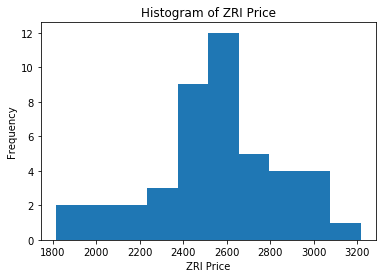

In [27]:
#create histogram of prices
pyplot.hist(data['Zri'],
            bins='auto')
pyplot.title('Histogram of ZRI Price')
pyplot.xlabel('ZRI Price')
pyplot.ylabel('Frequency')
pyplot.show()

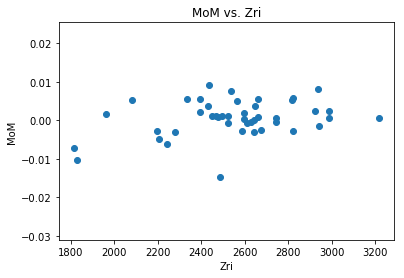

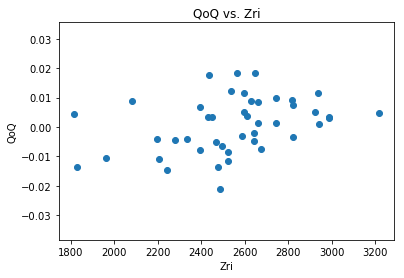

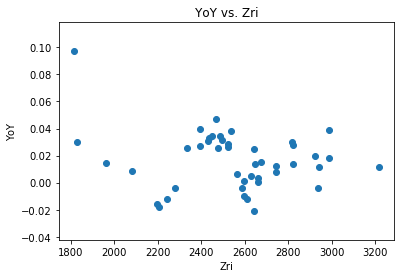

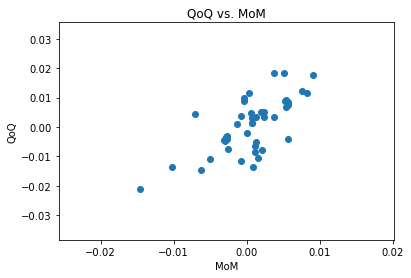

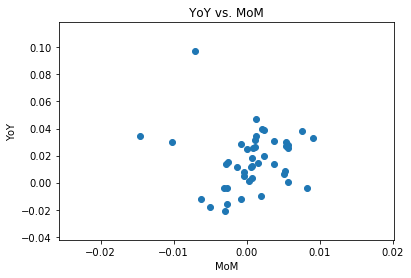

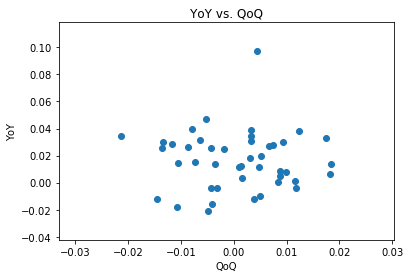

In [31]:
#make more plots
def varPlot(indVar, depVar):
    pyplot.scatter(data[indVar], data[depVar])
    pyplot.title(depVar + ' vs. ' + indVar)
    pyplot.xlabel(indVar)
    pyplot.ylabel(depVar)
    pyplot.show()
    
varPlot('Zri', 'MoM')
varPlot('Zri', 'QoQ')
varPlot('Zri', 'YoY')
varPlot('MoM', 'QoQ')
varPlot('MoM', 'YoY')
varPlot('QoQ', 'YoY')

None of the above relationships look very interesting to me. Anyone else have thoughts?

# ZRI Time Series

# Scraping Zillow Property by Property

In [1]:
#import libraries
import pandas
import requests
from bs4 import BeautifulSoup
import lxml

In [2]:
#get addresses
allProperties = pandas.read_csv('property-assessment-fy2017.csv')

C:\Users\StuBab\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
#set URLs
baseURL = 'http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id=X1-ZWz18viv1r9s0b_5cfwc'
addressURLStart = '&address='
cityStateURLStart = '&citystatezip='

In [18]:
#parse xml
def parseXML(response):
    xml = response.text.encode('utf-8')
    soup = BeautifulSoup(xml, 'lxml')
    return soup

In [20]:
#loop through
for i in range(0, len(allProperties['MAIL_ADDRESS'])):
    address = allProperties['MAIL_ADDRESS'][i]
    cityState = allProperties['MAIL CS'][i]
    addressURL = addressURLStart + address.replace(' ', '+')
    cityStateURL = cityStateURLStart + cityState.replace(' ', '+')
    response = requests.get(baseURL + addressURL + cityStateURL)
    test = parseXML(response)
    print(test)
    try:
        print(addressURL, test.findAll('latitude')[0].text)
    except:
        print('Not found.', addressURL)

<?xml version="1.0" encoding="utf-8"?><html><body><searchresults:searchresults xmlns:searchresults="http://www.zillow.com/static/xsd/SearchResults.xsd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemalocation="http://www.zillow.com/static/xsd/SearchResults.xsd https://www.zillowstatic.com/vstatic/6ce354c/static/xsd/SearchResults.xsd"><request><address></address><citystatezip></citystatezip></request><message><text>Error: this account has reached is maximum number of calls for today</text><code>7</code></message></searchresults:searchresults><!-- H:012  T:82ms  S:150  R:Wed Nov 29 12:53:30 PST 2017  B:5.0.50267.8-hotfix_2017-11-28.3ecc3df~hotfix-platform-for-2017-11-28.4b0f42f --></body></html>
Not found. &address=195+LEXINGTON+ST
